In [1]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle

Implementation for the diffusion-reaction system with a space-dependent reaction rate in paper https://arxiv.org/abs/2111.02801.
"""
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_bvp

l = 0.01


def k(x):
    return 0.1 + np.exp(-0.5 * (x - 0.5) ** 2 / 0.15**2)


def fun(x, y):
    return np.vstack((y[1], (k(x) * y[0] + np.sin(2 * np.pi * x)) / l))


def bc(ya, yb):
    return np.array([ya[0], yb[0]])


num = 100
xvals = np.linspace(0, 1, num)
y = np.zeros((2, xvals.size))
res = solve_bvp(fun, bc, xvals, y)



Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Compiling model...
'compile' took 0.383001 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [4.38e-01, 3.81e-03, 8.67e-01]    [4.99e-01, 3.81e-03, 8.67e-01]    []  
1000      [2.79e-03, 4.50e-04, 1.01e-02]    [2.98e-03, 4.50e-04, 1.01e-02]    []  
2000      [1.26e-04, 2.35e-06, 3.22e-04]    [1.19e-04, 2.35e-06, 3.22e-04]    []  
3000      [4.08e-05, 1.17e-06, 7.44e-05]    [4.48e-05, 1.17e-06, 7.44e-05]    []  
4000      [2.73e-05, 2.95e-07, 2.51e-05]    [3.00e-05, 2.95e-07, 2.51e-05]    []  
5000      [1.76e-05, 1.59e-07, 8.54e-06]    [1.89e-05, 1.59e-07, 8.54e-06]    []  
6000      [1.23e-05, 6.83e-08, 3.83e-06]    [1.28e-05, 6.83e-08, 3.83e-06]    []  
7000      [1.28e-05, 8.20e-06, 9.01e-06]    [1.31e-05, 8.20e-06, 9.01e-06]    []  
8000      [8.51e-06, 1.22e-08, 1.50e-06]    [8.68e-06, 1.22e-08, 1.50e-06]    []  
9000      [7.50e-06, 1.09e-08, 1.03e-06]    [7.72e-06, 1.09e-08, 1.03e-06]    []  
10000     [6.70

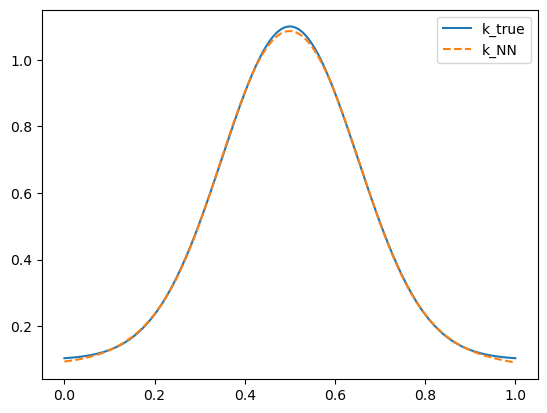

l2 relative error for u: 0.0009724775909333405


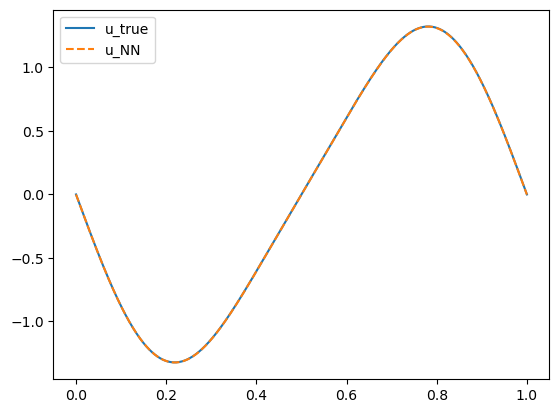

In [2]:
def gen_traindata(num):
    return np.reshape(xvals, (-1, 1)), np.reshape(res.sol(xvals)[0], (-1, 1))


geom = dde.geometry.Interval(0, 1)


def pde(x, y):
    u, k = y[:, 0:1], y[:, 1:2]
    du_xx = dde.grad.hessian(y, x, i=0, j=0, component=0)
    return l * du_xx - u * k - dde.backend.sin(2 * np.pi * x)


def func(x):
    return 0


ob_x, ob_u = gen_traindata(num)
observe_u = dde.icbc.PointSetBC(ob_x, ob_u, component=0)

bc = dde.icbc.DirichletBC(geom, func, lambda _,
                          on_boundary: on_boundary, component=0)

data = dde.data.PDE(
    geom,
    pde,
    bcs=[bc, observe_u],
    num_domain=50,
    num_boundary=8,
    train_distribution="uniform",
    num_test=1000,
)

net = dde.nn.PFNN([1, [20, 20], [20, 20], 2], "tanh", "Glorot uniform")
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)

losshistory, train_state = model.train(iterations=5000)

x = geom.uniform_points(500)
yhat = model.predict(x)
uhat, khat = yhat[:, 0:1], yhat[:, 1:2]

ktrue = k(x)
print("l2 relative error for k: " +
      str(dde.metrics.l2_relative_error(khat, ktrue)))

plt.figure()
plt.plot(x, ktrue, "-", label="k_true")
plt.plot(x, khat, "--", label="k_NN")
plt.legend()
plt.show()

utrue = res.sol(x)[0]
print("l2 relative error for u: " +
      str(dde.metrics.l2_relative_error(uhat, utrue)))

plt.figure()
plt.plot(x, utrue, "-", label="u_true")
plt.plot(x, uhat, "--", label="u_NN")
plt.legend()
plt.show()